<a href="https://colab.research.google.com/github/goleamit9/sentimentanalysis/blob/main/sentimenyanalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import the required libraries
##Author:Amit Kumar

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle

##NLTK Setup

In [29]:
# Setup NLTK resources
def setup_nltk():
    resources = ['punkt', 'stopwords', 'wordnet', 'omw-1.4']
    pos_taggers = ['averaged_perceptron_tagger_eng', 'averaged_perceptron_tagger']

    for res in resources:
        nltk.download(res, quiet=True)

    for tagger in pos_taggers:
        try:
            nltk.download(tagger, quiet=True)
            break
        except:
            continue

setup_nltk()

##Helper Functions

In [30]:
def get_wordnet_pos(treebank_tag):
    """Map POS tag to WordNet POS for lemmatization"""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def preprocess_text(text):
    """Clean, remove stopwords, and lemmatize text"""
    if pd.isnull(text):
        return ""

    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub('<.*?>', '', text)
    text = re.sub(r'[^\w\s]', '', text)

    text = text.lower().split()
    tagged = pos_tag(text)
    text = [
        lmtzr.lemmatize(word, get_wordnet_pos(tag))
        for word, tag in tagged
        if word not in stop_words
    ]
    return " ".join(text)

##Load the dataset

In [31]:
df=pd.read_csv('/content/sample_data/customer_reviews.csv')

##Basic data checks

In [32]:
df.head()

,detailed_review,sentiment
0,The color is slightly different from the pictu...,Neutral
1,The product arrived damaged and unusable.,Negative
2,Excellent build quality and fast performance.,Positive
3,"The product is okay, works as described but no...",Neutral
4,"Lightweight and easy to use, definitely worth ...",Positive


In [33]:
df.tail()

,detailed_review,sentiment
995,Customer service was unhelpful when I tried to...,Negative
996,"Lightweight and easy to use, definitely worth ...",Positive
997,Completely disappointed — it stopped working a...,Negative
998,Very slow and lags constantly.,Negative
999,"Packaging was fine, but delivery took longer t...",Neutral


In [34]:
df.shape

(1000, 2)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   detailed_review  1000 non-null   object
 1   sentiment        1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


In [36]:
df['detailed_review'].value_counts()

,count
detailed_review,
"Packaging was fine, but delivery took longer than expected.",82
This phone’s battery lasts all day and the camera quality is stunning!,79
The product exceeded my expectations in every way.,76
"Average quality, neither too good nor too bad.",75
Completely disappointed — it stopped working after two days.,70
"Lightweight and easy to use, definitely worth the price.",69
Excellent build quality and fast performance.,67
The color is slightly different from the pictures but still fine.,66
"It's functional, but I have seen better options.",66


In [37]:
df['sentiment'].value_counts()

,count
sentiment,
Positive,350
Neutral,347
Negative,303


In [38]:
df.isnull().sum()

,0
detailed_review,0
sentiment,0


##Data Visualizatiion

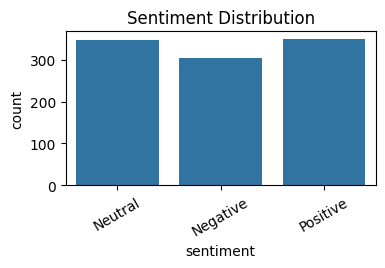

In [39]:
# sentiment distribution
plt.figure(figsize=(4,2))
sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Distribution')
plt.xticks(rotation=30)
plt.show()



*   Dataset is well balanced across three categories
*  Slightly more neutral and positive sentiment in comparision of negative sentiment



##Takes all the reviews in that Series and concatenates them into one long string, separated by spaces for all three sentiments


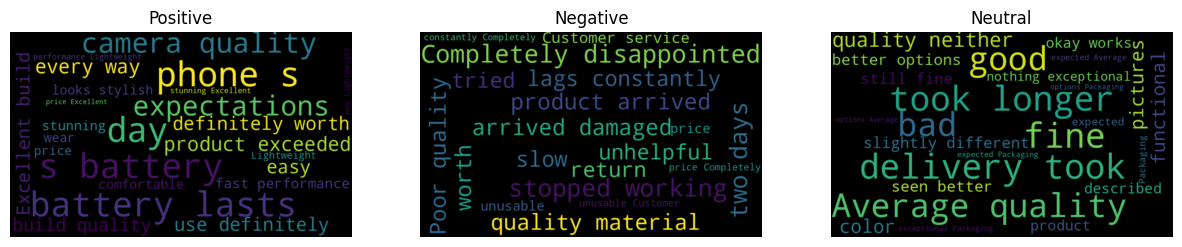

In [40]:
pos = " ".join(df[df['sentiment'] == 'Positive']['detailed_review'].astype(str))
neg = " ".join(df[df['sentiment'] == 'Negative']['detailed_review'].astype(str))
ntl = " ".join(df[df['sentiment'] == 'Neutral']['detailed_review'].astype(str))

wordcloud = WordCloud(height = 600, width = 1000, max_font_size =100)
plt.figure(figsize = (15,6))
plt.subplot(1,3,1)
plt.imshow(wordcloud.generate(pos), interpolation = 'bilinear')
plt.axis('off')
plt.title('Positive')

plt.subplot(1,3,2)
plt.imshow(wordcloud.generate(neg), interpolation = 'bilinear')
plt.axis('off')
plt.title('Negative')

plt.subplot(1,3,3)
plt.imshow(wordcloud.generate(ntl), interpolation = 'bilinear')
plt.axis('off')
plt.title('Neutral')

plt.show()

##Text Preprocessing

In [41]:
stop_words = set(stopwords.words('english'))
lmtzr = WordNetLemmatizer()

# Preprocess text
df['Clean_text'] = df['detailed_review'].astype(str).apply(preprocess_text)

print(df.head())

                                     detailed_review sentiment  \
0  The color is slightly different from the pictu...   Neutral   
1          The product arrived damaged and unusable.  Negative   
2      Excellent build quality and fast performance.  Positive   
3  The product is okay, works as described but no...   Neutral   
4  Lightweight and easy to use, definitely worth ...  Positive   

                                        Clean_text  
0      color slightly different picture still fine  
1                   product arrive damage unusable  
2         excellent build quality fast performance  
3  product okay work described nothing exceptional  
4      lightweight easy use definitely worth price  


##Label Encoding or mapping the text columns to numeric value

In [42]:
df['sentiment_label'] = df['sentiment'].map({"Positive": 1, "Neutral": 0, "Negative": -1})

In [43]:
df['sentiment_label'].value_counts()

,count
sentiment_label,
1,350
0,347
-1,303


##Train, test split, and vectorization

In [44]:
X = df['Clean_text']
y = df['sentiment_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert text to vector form
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,3))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(f"Train data shape: {X_train_vec.shape}, Test data shape: {X_test_vec.shape}")

Train data shape: (800, 175), Test data shape: (200, 175)


##Train the model

In [45]:
model = MultinomialNB()
model.fit(X_train_vec,y_train)

MultinomialNB()

In [46]:
y_pred = model.predict(X_test_vec)

##Evaluate the Model

Accuracy : 1.0
Classification Report: 
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00        61
     Neutral       1.00      1.00      1.00        69
    Positive       1.00      1.00      1.00        70

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



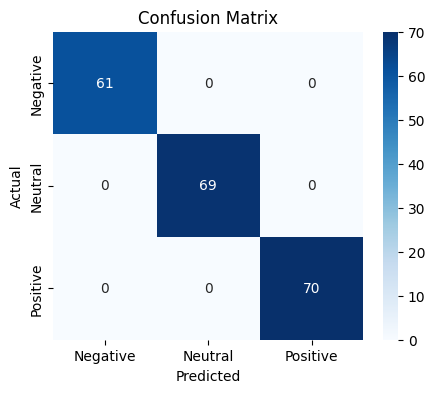

In [47]:
# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy : {acc}")

# Classification Report
print("Classification Report: ")
print(classification_report(y_test, y_pred, target_names=['Negative','Neutral','Positive']))

#Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=[-1, 0, 1])
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative','Neutral','Positive'],
            yticklabels=['Negative','Neutral','Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

**Observations:**
- Perfect classification on the test set.
- No misclassifications; reliable predictions.
- High performance suggests that the preprocessing, vectorization, and Naive Bayes model are extremely effective on this dataset.

### Save the Model & Vectorizer

In [48]:
# Save Naive Bayes model
with open('/content/sample_data/sentiment_analysis_model.pkl','wb') as model_file:
    pickle.dump(model, model_file)

# Save TF-IDF vectorizer
with open('/content/sample_data/vectorizer.pkl','wb') as vec_file:
    pickle.dump(vectorizer, vec_file)

print("Model & Vectorizer saved successfully.")

Model & Vectorizer saved successfully.


### Professional Insights & Recommendations

- Positive Reviews (350): Generally satisfied customers.
- Neutral Reviews (347): Mixed or indifferent feedback.
- Negative Reviews (303): Areas for improvement.

**Actionable Insight:** Focus on analyzing Negative reviews to address recurring issues.

### Recommendations
1. Monitor sentiment trends over time.
2. Deploy in real-time for new customer feedback.
3. Analyze Negative reviews to identify actionable improvements.
4. Expand dataset for more diverse reviews to improve model robustness.

**Conclusion:** The sentiment analysis model provides accurate insights into customer opinions, enabling data-driven decisions and improved customer satisfaction.